# Discrete Optimization

In this tutorial we will go into some of the details of optimizing a Euclidean landscape in discrete space. In MGSurvE, the discrete optimization of a landscape is a simplification of the continuous case, in which traps are only allowed to be placed in dwells. This application could be useful in urban environments, where we would expect traps and lures to be located in households or surveillance stations.

In [1]:
# Fix PROJ path ---------------------------------------------------------------
import os; 
os.environ['PROJ_LIB']=r'/opt/conda/pkgs/proj-9.2.1-ha5fc9e9_0/share/proj'
# Load libraries --------------------------------------------------------------
import pandas as pd
import matplotlib.pyplot as plt
import MGSurvE as srv
%matplotlib inline
# Setup data path and ID ------------------------------------------------------
(ID, OUT_PTH) = ('DiscreteGA', './out/')
srv.makeFolder(OUT_PTH)

We will setup a regular grid with 100 points (ten per side) and two trap-types. As we are working with the discrete case, it is important to setup the `sid` entry for each trap even if it's a dummy value:

In [2]:
PTS_NUM = 10
RADII = (-100, 100)
# Generate pointset -----------------------------------------------------------
xy = srv.ptsRegularGrid(PTS_NUM, (RADII, RADII)).T
# Re-shape pointset into dataframe --------------------------------------------
points = pd.DataFrame({
    'x': xy[0], 'y': xy[1], 
    't': [0]*len(xy[0])
})
# Setup traps -----------------------------------------------------------------
nullTraps = [0, 0, 0, 0]
traps = pd.DataFrame({
    'sid': nullTraps,
    'x': nullTraps, 'y': nullTraps,
    't': [0, 0, 1, 1], 'f': nullTraps
})
tKer = {
    0: {'kernel': srv.exponentialDecay, 'params': {'A': .5, 'b': .1}},
    1: {'kernel': srv.exponentialDecay, 'params': {'A': .5, 'b': .125}}
}

Once we have this in place we can go on instantiating our landscape object:

In [3]:
lnd = srv.Landscape(
    points, 
    kernelParams={'params': srv.MEDIUM_MOV_EXP_PARAMS, 'zeroInflation': .25}, 
    traps=traps, trapsKernels=tKer
)

And this time we will tweak some of the default settings of the GA optimizer manually:

In [4]:
GA_SETTINGS = {
    'generations': 250,
    'popSize': int(10*(lnd.trapsNumber*1.25)),
    'mating': {'cxpb': .3, 'indpb': 0.5},
    'mutation': {'mutpb': .4, 'indpb': 0.5},
    'selection': {'tSize': 4},
    'verbose': False
}
# Run optimization ------------------------------------------------------------
(lnd, logbook) = srv.optimizeDiscreteTrapsGA(
    lnd, 
    generations=GA_SETTINGS['generations'], 
    verbose=GA_SETTINGS['verbose'],
    pop_size=GA_SETTINGS['popSize'],
    mating_params=GA_SETTINGS['mating'], 
    mutation_params=GA_SETTINGS['mutation'], 
    selection_params=GA_SETTINGS['selection'],
)
# Export optimized landscape and log to disk ----------------------------------
srv.exportLog(logbook, OUT_PTH, '{}_LOG'.format(ID))
srv.dumpLandscape(lnd, OUT_PTH, '{}_LND'.format(ID), fExt='pkl')

Once our GA has run we would expect traps to be placed regularly across the landscape (in a square shape if it's 4 traps):

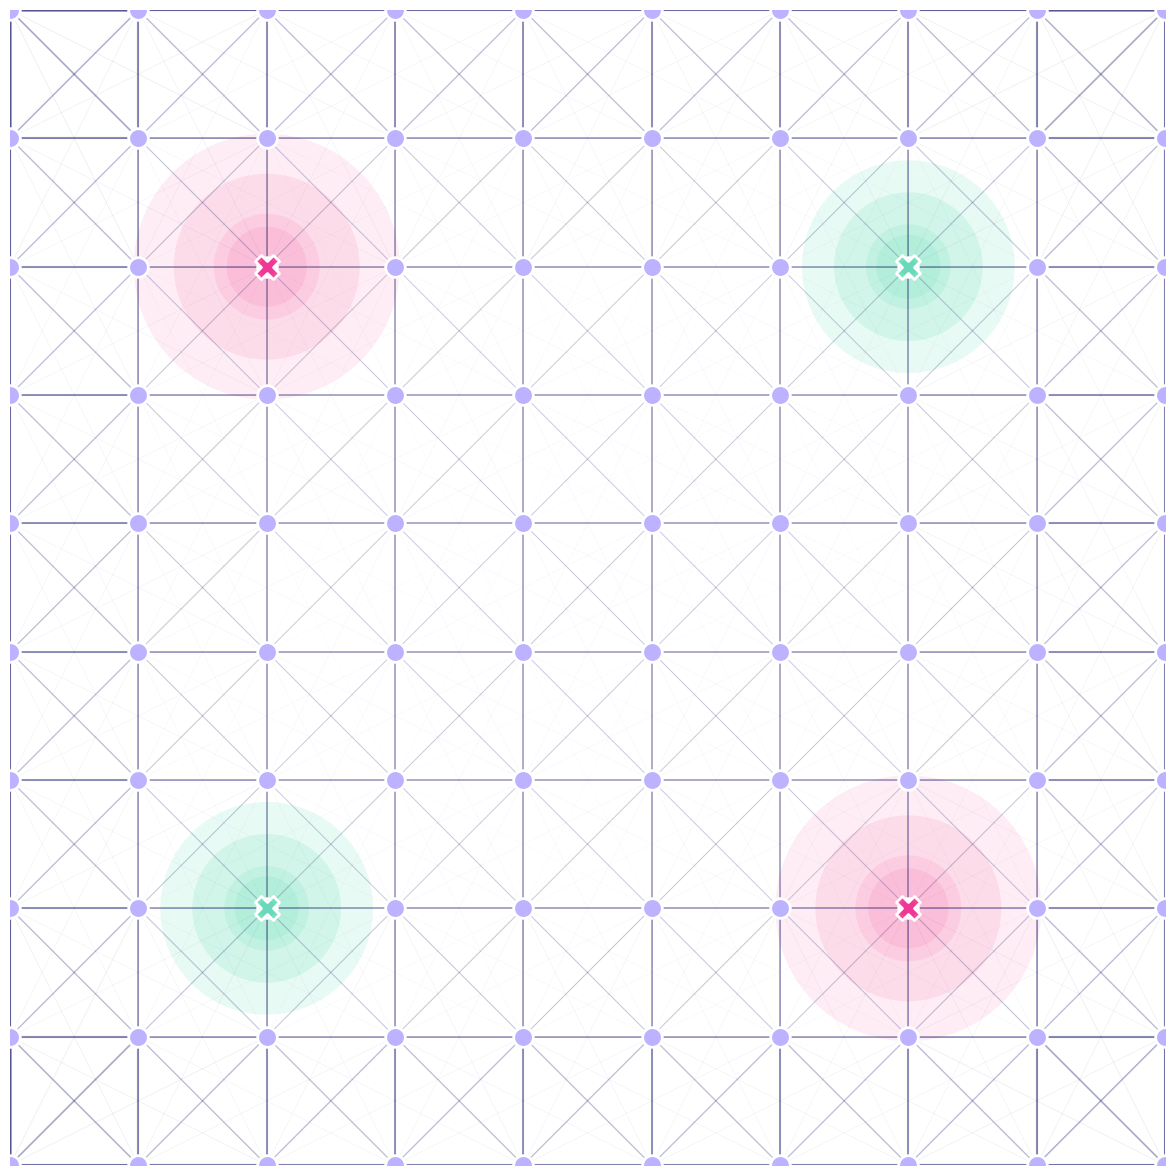

In [5]:
(fig, ax) = plt.subplots(1, 1, figsize=(15, 15), sharey=False)
lnd.plotSites(fig, ax, size=200)
lnd.plotTraps(fig, ax)
lnd.plotMaskedMigrationNetwork(fig, ax, alphaMin=.6, lineWidth=25)
srv.plotClean(fig, ax, bbox=lnd.landLimits)
fig.savefig(
    os.path.join(OUT_PTH, '{}.png'.format(ID)), 
    facecolor='w', bbox_inches='tight', pad_inches=0.1, dpi=150
)

<hr>

# More Information

* [MGSurvE's Extensive Discrete Optimization Tutorial](https://chipdelmal.github.io/MGSurvE/build/html/GA_discrete.html)
* [MGSurvE's Discrete Optimization API entry](https://chipdelmal.github.io/MGSurvE/build/html/MGSurvE.html#MGSurvE.optimization.optimizeDiscreteTrapsGA)
* [DEAP's documentation](https://deap.readthedocs.io/en/master/)
